## Getting online predictions with xgboost
- https://cloud.google.com/ai-platform/prediction/docs/getting-predictions-xgboost#about-data

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.1</div>
<div style="text-align: right"> Last update: 2023.7.1</div>

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
import json
import os
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [4]:
COLUMNS = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income-level'
)

In [5]:
CATEGORICAL_COLUMNS = (
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
)

In [7]:
with open('data/census/adult.data', 'r') as train_data:
    raw_training_data = pd.read_csv(train_data, header=None, names = COLUMNS)
    
X_train = raw_training_data.drop('income-level', axis = 1)
y_train = (raw_training_data['income-level'] == ' >50K')

In [9]:
with open('./data/census/adult.test', 'r') as test_data:
    raw_testing_data = pd.read_csv(test_data, names=COLUMNS, skiprows=1)
# remove column we are trying to predict ('income-level') from features list
X_test = raw_testing_data.drop('income-level', axis=1)
# create training labels list
y_test = (raw_testing_data['income-level'] == ' >50K.')

In [10]:
encoders = {col: LabelEncoder() for col in CATEGORICAL_COLUMNS}
encoders

{'workclass': LabelEncoder(),
 'education': LabelEncoder(),
 'marital-status': LabelEncoder(),
 'occupation': LabelEncoder(),
 'relationship': LabelEncoder(),
 'race': LabelEncoder(),
 'sex': LabelEncoder(),
 'native-country': LabelEncoder()}

In [11]:
for col in CATEGORICAL_COLUMNS:
    X_train[col] = encoders[col].fit_transform(X_train[col])
for col in CATEGORICAL_COLUMNS:
    X_test[col] = encoders[col].fit_transform(X_test[col])

모델 학습 및 내보내기   
- Booster 객체의 save_model 메서드나 Python pickle 라이브러리를 사용하여 모델을 내보낼 수 있습니다.

In [12]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest =xgb.DMatrix(X_test)

In [13]:
# 모델 학습 및 저장 
bst = xgb.train(
    params={}, 
    dtrain = dtrain, 
    num_boost_round=20
    )

In [14]:
bst.save_model("./model/xgb_model.bst")

In [15]:
bst

모델 내보내기 별 파일 확장자

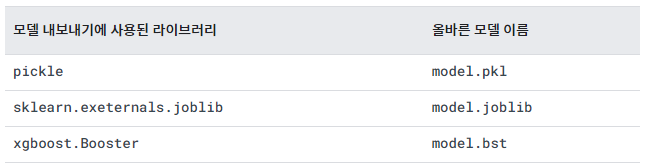

## 사이킷런으로 온라인 예측

- https://cloud.google.com/ai-platform/prediction/docs/using-pipelines-for-preprocessing?hl=ko

In [17]:
import joblib
import json
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer

In [18]:
COLUMNS = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income-level'
)

In [19]:
CATEGORICAL_COLUMNS = (
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
)

In [20]:
with open("./data/census/adult.data", "r") as train_data:
    train = pd.read_csv(train_data, header=None, names = COLUMNS)

In [21]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-level
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [22]:
# 데이터프레임을 리스트들의 리스트로 변환한다.
X_train = train.drop('income-level', axis = 1).values.tolist()
y_train = (raw_training_data['income-level'] == ' >50K').values.tolist()

In [23]:
X_train[:5]

[[39,
  ' State-gov',
  77516,
  ' Bachelors',
  13,
  ' Never-married',
  ' Adm-clerical',
  ' Not-in-family',
  ' White',
  ' Male',
  2174,
  0,
  40,
  ' United-States'],
 [50,
  ' Self-emp-not-inc',
  83311,
  ' Bachelors',
  13,
  ' Married-civ-spouse',
  ' Exec-managerial',
  ' Husband',
  ' White',
  ' Male',
  0,
  0,
  13,
  ' United-States'],
 [38,
  ' Private',
  215646,
  ' HS-grad',
  9,
  ' Divorced',
  ' Handlers-cleaners',
  ' Not-in-family',
  ' White',
  ' Male',
  0,
  0,
  40,
  ' United-States'],
 [53,
  ' Private',
  234721,
  ' 11th',
  7,
  ' Married-civ-spouse',
  ' Handlers-cleaners',
  ' Husband',
  ' Black',
  ' Male',
  0,
  0,
  40,
  ' United-States'],
 [28,
  ' Private',
  338409,
  ' Bachelors',
  13,
  ' Married-civ-spouse',
  ' Prof-specialty',
  ' Wife',
  ' Black',
  ' Female',
  0,
  0,
  40,
  ' Cuba']]

In [26]:
with open('./data/census/adult.test', 'r') as test_data:
    test = pd.read_csv(test_data, names=COLUMNS, skiprows=1)
# Remove the column we are trying to predict ('income-level') from our features list
# Convert the Dataframe to a lists of lists
X_test = test.drop('income-level', axis=1).values.tolist()
# Create our training labels list, convert the Dataframe to a lists of lists
y_test = (test['income-level'] == ' >50K.').values.tolist()

In [27]:
categorical_pipelines = []

In [28]:
# 각 범주형 열을 개별적으로 추출하여 숫자 값으로 변환해야 합니다.
# 이를 위해 각 범주 열은 다음을 통해 하나의 특징 열을 추출하는 파이프라인을 사용합니다.
# SelectKBest(k=1)를 통해 하나의 특징 열을 추출하는 파이프라인과 범주형 값을 숫자로 변환하는 LabelBinarizer()를 사용합니다.
# 아래에 생성된 점수 배열이 특징 열을 선택하고 추출합니다. 점수 배열은
# COLUMNS를 반복하고 CATEGORICAL_COLUMN인지 확인하여 생성됩니다.

In [29]:
for i, col in enumerate(COLUMNS[:-1]):
    if col in CATEGORICAL_COLUMNS:
        scores = []
        
        for j in range(len(COLUMNS[:-1])):
            if i == j : # This column is the categorical column we want to extract.
                scores.append(1) # 이 컬럼을 선택하기 위해 1로 설정
            else:
                scores.append(0)
                
        skb = SelectKBest(k = 1)
        skb.scores_ = scores
        
        # 카테고리 컬럼을 수치형으로 변환
        lbn = LabelBinarizer()
        r = skb.transform(X_train)
        lbn.fit(r)
        
        # Create the pipeline to extract the categorical feature
        categorical_pipelines.append(
            ('categorical-{}'.format(i), Pipeline([
                ('SKB-{}'.format(i), skb),
                ('LBN-{}'.format(i), lbn)])))

In [30]:
categorical_pipelines

[('categorical-1',
  Pipeline(steps=[('SKB-1', SelectKBest(k=1)), ('LBN-1', LabelBinarizer())])),
 ('categorical-3',
  Pipeline(steps=[('SKB-3', SelectKBest(k=1)), ('LBN-3', LabelBinarizer())])),
 ('categorical-5',
  Pipeline(steps=[('SKB-5', SelectKBest(k=1)), ('LBN-5', LabelBinarizer())])),
 ('categorical-6',
  Pipeline(steps=[('SKB-6', SelectKBest(k=1)), ('LBN-6', LabelBinarizer())])),
 ('categorical-7',
  Pipeline(steps=[('SKB-7', SelectKBest(k=1)), ('LBN-7', LabelBinarizer())])),
 ('categorical-8',
  Pipeline(steps=[('SKB-8', SelectKBest(k=1)), ('LBN-8', LabelBinarizer())])),
 ('categorical-9',
  Pipeline(steps=[('SKB-9', SelectKBest(k=1)), ('LBN-9', LabelBinarizer())])),
 ('categorical-13',
  Pipeline(steps=[('SKB-13', SelectKBest(k=1)), ('LBN-13', LabelBinarizer())]))]

In [31]:
# Create pipeline to extract the numerical features
skb = SelectKBest(k=6)
# From COLUMNS use the features that are numerical
skb.scores_ = [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]
categorical_pipelines.append(('numerical', skb))

In [32]:
categorical_pipelines

[('categorical-1',
  Pipeline(steps=[('SKB-1', SelectKBest(k=1)), ('LBN-1', LabelBinarizer())])),
 ('categorical-3',
  Pipeline(steps=[('SKB-3', SelectKBest(k=1)), ('LBN-3', LabelBinarizer())])),
 ('categorical-5',
  Pipeline(steps=[('SKB-5', SelectKBest(k=1)), ('LBN-5', LabelBinarizer())])),
 ('categorical-6',
  Pipeline(steps=[('SKB-6', SelectKBest(k=1)), ('LBN-6', LabelBinarizer())])),
 ('categorical-7',
  Pipeline(steps=[('SKB-7', SelectKBest(k=1)), ('LBN-7', LabelBinarizer())])),
 ('categorical-8',
  Pipeline(steps=[('SKB-8', SelectKBest(k=1)), ('LBN-8', LabelBinarizer())])),
 ('categorical-9',
  Pipeline(steps=[('SKB-9', SelectKBest(k=1)), ('LBN-9', LabelBinarizer())])),
 ('categorical-13',
  Pipeline(steps=[('SKB-13', SelectKBest(k=1)), ('LBN-13', LabelBinarizer())])),
 ('numerical', SelectKBest(k=6))]

featureUnion을 사용하면 여러개의 파이프라인을 연결할 수 있다.

In [33]:
preprocess = FeatureUnion(categorical_pipelines)
preprocess

FeatureUnion(transformer_list=[('categorical-1',
                                Pipeline(steps=[('SKB-1', SelectKBest(k=1)),
                                                ('LBN-1', LabelBinarizer())])),
                               ('categorical-3',
                                Pipeline(steps=[('SKB-3', SelectKBest(k=1)),
                                                ('LBN-3', LabelBinarizer())])),
                               ('categorical-5',
                                Pipeline(steps=[('SKB-5', SelectKBest(k=1)),
                                                ('LBN-5', LabelBinarizer())])),
                               ('categorical-6',
                                Pipeline(steps=[('SKB-6', SelectK...
                                Pipeline(steps=[('SKB-7', SelectKBest(k=1)),
                                                ('LBN-7', LabelBinarizer())])),
                               ('categorical-8',
                                Pipeline(steps=[('SKB-8', SelectKBest(k=1)),
                                                ('LBN-8', LabelBinarizer())])),
                               ('categorical-9',
                                Pipeline(steps=[('SKB-9', SelectKBest(k=1)),
                                                ('LBN-9', LabelBinarizer())])),
                               ('categorical-13',
                                Pipeline(steps=[('SKB-13', SelectKBest(k=1)),
                                                ('LBN-13', LabelBinarizer())])),
                               ('numerical', SelectKBest(k=6))])

In [34]:
classifier = RandomForestClassifier()

In [35]:
classifier.fit(preprocess.transform(X_train), y_train)

RandomForestClassifier()

In [36]:
pipeline = Pipeline([
    ('union', preprocess),
    ('classifier', classifier)
])

In [37]:
pipeline

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('categorical-1',
                                                 Pipeline(steps=[('SKB-1',
                                                                  SelectKBest(k=1)),
                                                                 ('LBN-1',
                                                                  LabelBinarizer())])),
                                                ('categorical-3',
                                                 Pipeline(steps=[('SKB-3',
                                                                  SelectKBest(k=1)),
                                                                 ('LBN-3',
                                                                  LabelBinarizer())])),
                                                ('categorical-5',
                                                 Pipeline(steps=[('SKB-5',
                                                                  SelectKBest(k=1)),
                                                                 ('LBN-5',
                                                                  LabelBinarizer())])),
                                                ('categorical-6',
                                                 Pipelin...
                                                                  LabelBinarizer())])),
                                                ('categorical-8',
                                                 Pipeline(steps=[('SKB-8',
                                                                  SelectKBest(k=1)),
                                                                 ('LBN-8',
                                                                  LabelBinarizer())])),
                                                ('categorical-9',
                                                 Pipeline(steps=[('SKB-9',
                                                                  SelectKBest(k=1)),
                                                                 ('LBN-9',
                                                                  LabelBinarizer())])),
                                                ('categorical-13',
                                                 Pipeline(steps=[('SKB-13',
                                                                  SelectKBest(k=1)),
                                                                 ('LBN-13',
                                                                  LabelBinarizer())])),
                                                ('numerical',
                                                 SelectKBest(k=6))])),
                ('classifier', RandomForestClassifier())])